In [50]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
import os

path = '/content/drive/MyDrive/Computer Vision/Face Recognition/Notebooks'
os.chdir(path)
print(os.getcwd())

/content/drive/MyDrive/Computer Vision/Face Recognition/Notebooks


In [52]:
 #checking dependencies
 !pip show tensorflow

Name: tensorflow
Version: 2.13.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine-rl


In [53]:
#importing dependencies
import os
import random

import cv2
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D

In [ ]:
#creating folder structure
os.mkdir(path='../data')
os.mkdir(path = '../data/anchor')
os.mkdir(path='../data/positive')
os.mkdir(path='../data/negative')

In [54]:
##paths
base_path = '/content/drive/MyDrive/Computer Vision/Face Recognition'

notebook_path = '/content/drive/MyDrive/Computer Vision/Face Recognition/Notebooks'
data_path = '/content/drive/MyDrive/Computer Vision/Face Recognition/data'

anchor_path ='/content/drive/MyDrive/Computer Vision/Face Recognition/data/anchor'
pos_path = '/content/drive/MyDrive/Computer Vision/Face Recognition/data/positive'
neg_path = '/content/drive/MyDrive/Computer Vision/Face Recognition/data/negative'

## Data Collection
- Anchor Examples   -->   webcam using opencv
- Positive Examples -->   webcam using opencv
- Negative Examples -->   labelled faces in wild (opensource dataset)


labelled faces in wild : https://vis-www.cs.umass.edu/lfw/

### Collecting Negative Class Data

In [ ]:
#unzipping tar gz labelled faces in wild dataset
os.chdir(data_path)
print(os.getcwd())
!tar -xf lfw.tgz

/content/drive/MyDrive/Computer Vision/Face Recognition/data


In [ ]:
for directory in os.listdir('lfw'):
  dir = os.path.join('lfw', directory)
  for file in os.listdir(dir):
    ex_path = os.path.join('lfw', directory, file)
    new_path = os.path.join(neg_path, file)
    os.replace(ex_path, new_path)

### Collecting Anchor and Positive Class Data
Note:
- Following code will work on local runtime only.

In [ ]:
'''
#establishing a connection to the webcam
cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame =cap.read()

    #display image to screen
    cv2.imshow('Image Collection', frame)
    frame = frame[120:120+250, 280:280+250, :]

    #collect anchors
    if cv2.waitKey(1) & 0XFF == ord('a'): # press key - a to capture anchor imgaes
        #create unique file path
        imgname = os.path.join(anc_path, '{}.jpg'.format(uuid.uuid1()))
        #write out anchor image
        cv2.imwrite(imgname, frame)

    #collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'): # press key - a to capture positive imgaes
        #create unique file path
        imgname = os.path.join(pos_path, '{}.jpg'.format(uuid.uuid1()))
        #write out anchor image
        cv2.imwrite(imgname, frame)

    #breaking the loop
    if cv2.waitKey(1) & 0XFF == ord('q'): # press key - q to exit
        break

#shut the webcam
cap.release()
cv2.destroyAllWindows()
'''

"\n#establishing a connection to the webcam\ncap = cv2.VideoCapture(0)\n\nwhile cap.isOpened():\n    ret, frame =cap.read()\n    \n    #display image to screen\n    cv2.imshow('Image Collection', frame)\n    frame = frame[120:120+250, 280:280+250, :]\n    \n    #collect anchors\n    if cv2.waitKey(1) & 0XFF == ord('a'): # press key - a to capture anchor imgaes\n        #create unique file path\n        imgname = os.path.join(anc_path, '{}.jpg'.format(uuid.uuid1()))\n        #write out anchor image\n        cv2.imwrite(imgname, frame)\n        \n    #collect positives\n    if cv2.waitKey(1) & 0XFF == ord('p'): # press key - a to capture positive imgaes\n        #create unique file path\n        imgname = os.path.join(pos_path, '{}.jpg'.format(uuid.uuid1()))\n        #write out anchor image\n        cv2.imwrite(imgname, frame)\n\n    #breaking the loop\n    if cv2.waitKey(1) & 0XFF == ord('q'): # press key - q to exit\n        break\n\n#shut the webcam  \ncap.release()\ncv2.destroyAllWin

## Data Preparation

- Scale and Resize
- Labelling
- Train, test split

In [55]:
# getting image directories
anchor = tf.data.Dataset.list_files(anchor_path+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(pos_path+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(neg_path+'/*.jpg').take(300)

In [56]:
# preprocessing
def preprocess(file_path):

  #read img from file path
  byte_img = tf.io.read_file(file_path)
  #decode byte type to jpg
  img = tf.io.decode_jpeg(byte_img)
  #resize
  img = tf.image.resize(img, (105,105))
  #rescaling
  img = img/255.0
  return img

In [57]:
# labeling
# (anchor, positive) --> 1
# (anchor, negative) --> 0

positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [58]:
data

<_ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [59]:
samples = data.as_numpy_iterator()
example = samples.next()
example

(b'/content/drive/MyDrive/Computer Vision/Face Recognition/data/anchor/688fa77a-64d5-11ee-a8da-14f6d8eefcae.jpg',
 b'/content/drive/MyDrive/Computer Vision/Face Recognition/data/positive/5f7539eb-64d6-11ee-baa1-14f6d8eefcae.jpg',
 1.0)

In [60]:
# helper function
def preprocess_twin(input_img, validation_img, label):

  return(preprocess(input_img), preprocess(validation_img), label)

In [61]:
imgs = preprocess_twin(*example)

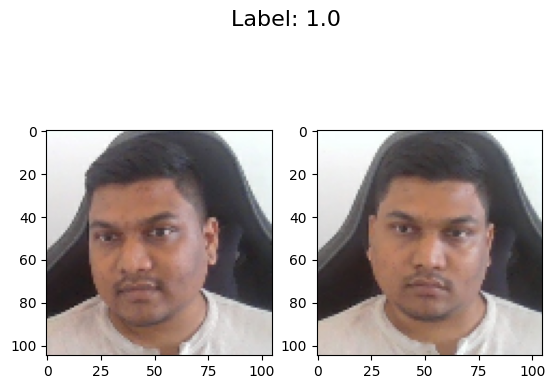

In [62]:
for i in range(2):
  plt.subplot(1,2, i+1)
  plt.imshow(imgs[i])

plt.suptitle(f'Label: {imgs[2]}', fontsize = 16)
plt.show()

In [63]:
#buiding dataloader pipeline

data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [15]:
samples = data.as_numpy_iterator()
imgs = samples.next()

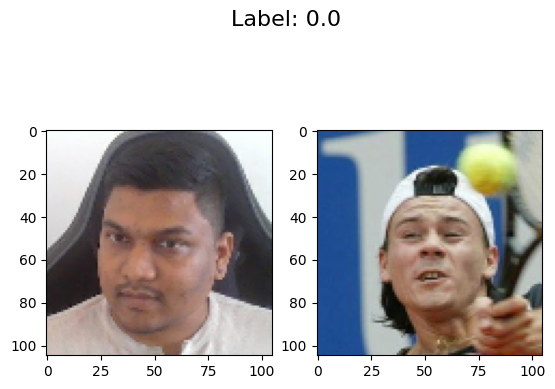

In [16]:
for i in range(2):
  plt.subplot(1,2, i+1)
  plt.imshow(imgs[i])

plt.suptitle(f'Label: {imgs[2]}', fontsize = 16)
plt.show()

In [77]:
## train-test split
train_data = data.take(round(len(data)*0.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

test_data = data.skip(round(len(data)*0.7))
test_data = test_data.take(round(len(data)*0.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

## Model Building

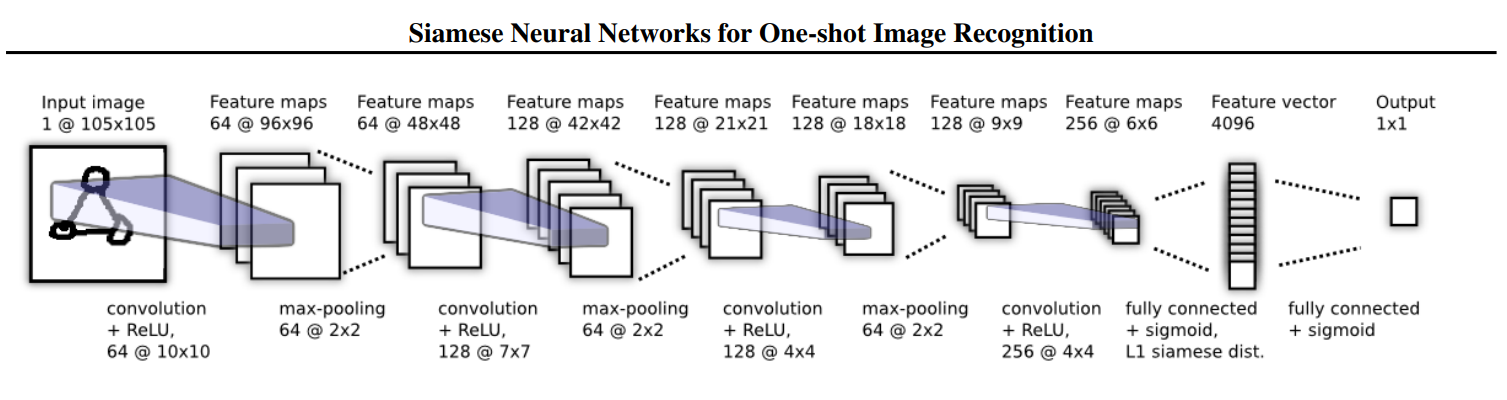

img ref: https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf

In [65]:
## building embedding layer

def make_embedding():

  input = Input(shape=(105,105,3), name = 'Input')

  #first block
  conv1 = Conv2D(filters=64, kernel_size=(10, 10), activation='relu', name='Conv-1')(input)
  pool1 = MaxPooling2D(pool_size=(2,2), padding='same', name='Max-Pooling-1')(conv1)

  #second block
  conv2 = Conv2D(filters=128, kernel_size=(7, 7), activation='relu', name='Conv-2')(pool1)
  pool2 = MaxPooling2D(pool_size=(2,2), padding='same', name='Max-Pooling-2')(conv2)

  #third block
  conv3 = Conv2D(filters=128, kernel_size=(4, 4), activation='relu', name='Conv-3')(pool2)
  pool3 = MaxPooling2D(pool_size=(2,2), padding='same', name='Max-Pooling-3')(conv3)

  #fourth block
  conv4 = Conv2D(filters=256, kernel_size=(4, 4), activation='relu', name='Conv-4')(pool3)
  flat = Flatten(name= 'Flat')(conv4)
  fc1 = Dense(4096, activation='sigmoid', name='FullyConnected-1')(flat)

  return Model(inputs=[input] , outputs=[fc1], name='Embedding')

In [66]:
embedding = make_embedding()
embedding.summary()

Model: "Embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 105, 105, 3)]     0         
                                                                 
 Conv-1 (Conv2D)             (None, 96, 96, 64)        19264     
                                                                 
 Max-Pooling-1 (MaxPooling2  (None, 48, 48, 64)        0         
 D)                                                              
                                                                 
 Conv-2 (Conv2D)             (None, 42, 42, 128)       401536    
                                                                 
 Max-Pooling-2 (MaxPooling2  (None, 21, 21, 128)       0         
 D)                                                              
                                                                 
 Conv-3 (Conv2D)             (None, 18, 18, 128)       26

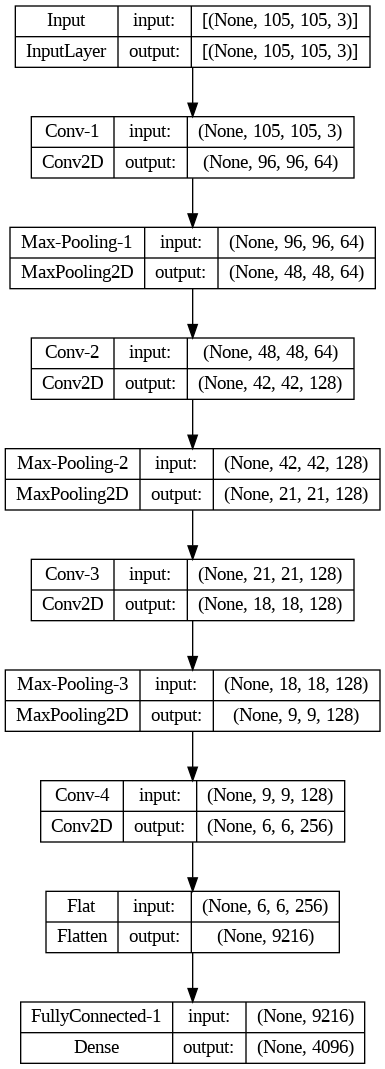

In [67]:
tf.keras.utils.plot_model(embedding, to_file='embedding.png', show_shapes=True)

In [68]:
## building distance layer

class L1Dist(Layer):

  def __init(self, **kwargs):
    super().__init__()

  #similarity calculations
  def call(self, input_embedding, validation_embedding):
    return tf.math.abs(input_embedding - validation_embedding)

In [69]:
##building Siamese network

def siamese_network():

  input_img = Input(shape=(105,105,3), name='Input_image')
  validation_img = Input(shape=(105,105,3), name='Validation_image')

  dist_layer = L1Dist()
  dist_layer._name = 'DistanceLayer'
  distances = dist_layer(embedding(input_img), embedding(validation_img))

  #classification layer
  clf = Dense(1, activation='sigmoid')(distances)

  return(Model(inputs=[input_img, validation_img], outputs = clf, name='SiameseNetwork'))

In [70]:
siamese = siamese_network()
siamese.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input_image (InputLayer)    [(None, 105, 105, 3)]        0         []                            
                                                                                                  
 Validation_image (InputLay  [(None, 105, 105, 3)]        0         []                            
 er)                                                                                              
                                                                                                  
 Embedding (Functional)      (None, 4096)                 3896044   ['Input_image[0][0]',         
                                                          8          'Validation_image[0][0]']    
                                                                                     

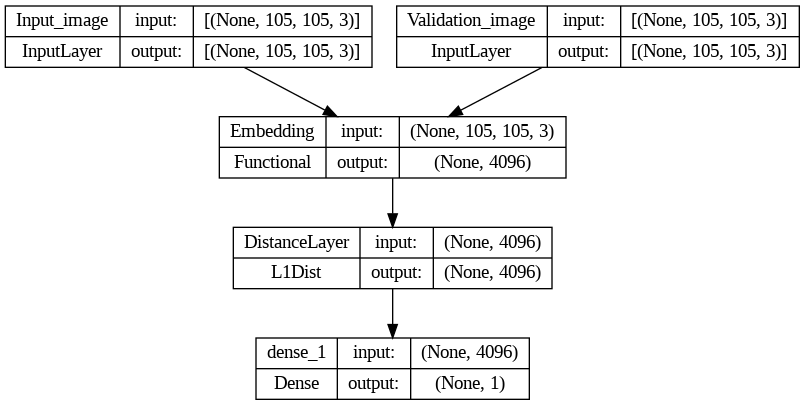

In [71]:
tf.keras.utils.plot_model(siamese, to_file='SiameseNetwork.png', show_shapes=True)

## Model Training
- Define Loss Function
- Setup Optimizer
- Create Training Loop
- Train the `Model`

In [79]:
#loss function
binary_loss = tf.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(1e-4)

In [41]:
#logging checkpoints
os.mkdir('../training_checkpoints')
checkpoints_dir = '../training_checkpoints'
checkpoint_pre = os.path.join(checkpoints_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(optimizer = optimizer, siamese=siamese)

In [80]:
#train step function
@tf.function
def train_step(batch):

  with tf.GradientTape() as tape:

    #get anchor and positive/negative
    X = batch[:2]
    #get label
    y = batch[2]

    #forward pass
    y_hat = siamese(X, training = True)
    #calculate loss
    loss = binary_loss(y, y_hat)

  #gradient computation
  grad = tape.gradient(loss, siamese.trainable_variables)

  #optimize and update weights and apply to siamese model
  optimizer.apply_gradients(zip(grad, siamese.trainable_variables))

  return loss

In [81]:
#training loop
def train(data, epochs):

  #loop throuch each epoch
  for epoch in range(1, epochs+1):
    print(f'\n Epoch {epoch}/{epochs}')
    progbar = tf.keras.utils.Progbar(len(data))

    #loop through each batch
    for idx, batch in enumerate(data):

      train_step(batch)
      progbar.update(idx+1)

    #save checkpoint
    if epoch % 10 == 0:
      checkpoint.save(file_prefix=checkpoint_pre)

In [83]:
epochs = 50

train(data=train_data, epochs=epochs)


 Epoch 1/50
27/27 [==============================] - 1s 45ms/step

 Epoch 2/50
27/27 [==============================] - 1s 41ms/step

 Epoch 3/50
27/27 [==============================] - 1s 41ms/step

 Epoch 4/50
27/27 [==============================] - 1s 40ms/step

 Epoch 5/50
27/27 [==============================] - 1s 41ms/step

 Epoch 6/50
27/27 [==============================] - 1s 41ms/step

 Epoch 7/50
27/27 [==============================] - 1s 41ms/step

 Epoch 8/50
27/27 [==============================] - 1s 40ms/step

 Epoch 9/50
27/27 [==============================] - 1s 41ms/step

 Epoch 10/50
27/27 [==============================] - 1s 41ms/step

 Epoch 11/50
27/27 [==============================] - 1s 41ms/step

 Epoch 12/50
27/27 [==============================] - 1s 41ms/step

 Epoch 13/50
27/27 [==============================] - 1s 41ms/step

 Epoch 14/50
27/27 [==============================] - 1s 40ms/step

 Epoch 15/50
27/27 [==============================] - 1s

## Model Evaluation

In [96]:
from tensorflow.keras.metrics import Precision
from tensorflow.keras.metrics import Recall

test_input, test_val, y_true = test_data.as_numpy_iterator().next()

predictions = siamese.predict([test_input, test_val])

1/1 [==============================] - 0s 28ms/step


In [97]:
predictions

array([[4.9056284e-06],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [9.9999464e-01],
       [1.9364566e-06],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [6.8323851e-13],
       [5.0485243e-09],
       [1.0000000e+00],
       [3.5399450e-10],
       [2.7605229e-09],
       [2.8188476e-06]], dtype=float32)

In [98]:
y_hat = (predictions>0.5).astype(int)
y_hat

array([[0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0]])

In [99]:
m = Recall()
m.update_state(y_true, y_hat)
m.result().numpy()

1.0

In [100]:
p = Precision()
p.update_state(y_true, y_hat)
p.result().numpy()

1.0

## Save Model

In [108]:
!pwd

/content/drive/MyDrive/Computer Vision/Face Recognition/Notebooks


In [109]:
os.mkdir('../Models')
siamese.save('../Models/siamese.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [110]:
#reload model
model = tf.keras.models.load_model('..//Models/siamese.h5',
                                   custom_objects={
                                      'L1Dist':L1Dist,
                                      'BinaryLoss': tf.keras.losses.BinaryCrossentropy
                                   })